In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalMaxPooling1D, Embedding, LSTM, Dense
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import string
import re
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kulreen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kulreen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kulreen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv('D:/Sentiment Dataset/archive/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)


In [3]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Rename columns for clarity
df.columns = ['category', 'id', 'date', 'query', 'user', 'tweet']

In [5]:
#0-Negative Sentiment
#4-Positive Sentiment
#We convert 4 to 1

df['category'] = df['category'].replace(4, 1)

<Axes: xlabel='category'>

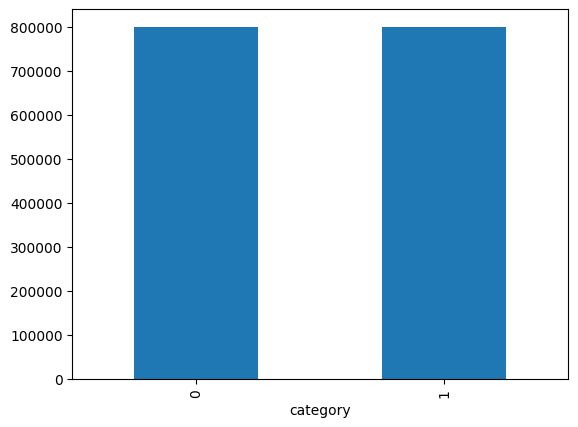

In [6]:
# a bar chart showing the count of comments in each category
df['category'].value_counts().plot(kind='bar')

In [7]:
df = df[['category', 'tweet']]

In [8]:
df['length'] = df['tweet'].str.len()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   category  1600000 non-null  int64 
 1   tweet     1600000 non-null  object
 2   length    1600000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 36.6+ MB


In [10]:
df['tweet'].iloc[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

<Axes: ylabel='Frequency'>

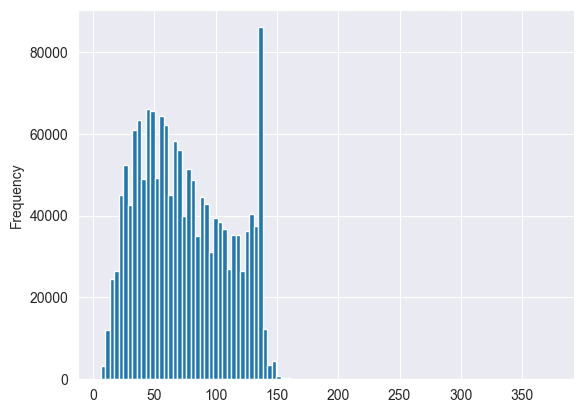

In [11]:
sns.set_style('darkgrid')
df['length'].plot(bins=100, kind='hist')

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
category,1600000.0,0.500000,0.500000,0.0,0.0,0.5,1.0,1.0
length,1600000.0,74.090111,36.441139,6.0,44.0,69.0,104.0,374.0


In [13]:
df['category'] = df['category'].map({0: 'negative', 1: 'positive'})

In [14]:
#Checking the null values in the dataset
df.isnull().sum()

category    0
tweet       0
length      0
dtype: int64

In [15]:
#replacing url with string
def replace_url(text):
    return re.sub(r'https?:\/\/\S+|www\.\S+', 'URL', text)


In [16]:
#removing html
def remove_html(text):
    return re.sub('<.*?>', '', text)

In [17]:
#replacing mentions with string user
def replace_mentions(text):
    return re.sub('@\S*','user',text,flags=re.IGNORECASE)

In [18]:
#replacing number with string number
def replace_num(text):
    return re.sub(r'\d+', 'NUMBER', text)

In [19]:
def replace_heart(text):
  return re.sub('<3', 'HEART', text)

In [20]:
def remove_stopwords(text):
  text= ' '.join([word for word in text.split() if word not in stopwords.words('english')])
  return text

In [21]:
def remove_punctuations(text):
    text=''.join([word for word in text if word not in string.punctuation])
    return text

In [22]:
def remove_alphanumeric(text):
    return re.sub('\w*\d+\w*','',text)

In [23]:
#reducing words to their root form
def lemmatization(text):
  lm = WordNetLemmatizer()
  text= ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
  return text
     

In [24]:
def clean_text(text):
  text = str(text).lower()
  text =replace_url(text)
  text = remove_punctuations(text)
  text = remove_alphanumeric(text)
  text = replace_heart(text)
  text = remove_stopwords(text)
  text = remove_html(text)
  text = replace_mentions(text)
  text = lemmatization(text)
  text = replace_num(text)
  return text

In [25]:
df['tweet'] = df['tweet'].apply(clean_text)


In [26]:
df['tweet']

0          switchfoot URL awww thats bummer shoulda get d...
1          upset cant update facebook texting might cry r...
2          kenichan dive many time ball manage save rest ...
3                            whole body feel itchy like fire
4                     nationwideclass behave im mad cant see
                                 ...                        
1599995                           wake school best feel ever
1599996       thewdbcom cool hear old walt interview â« URL
1599997                       ready mojo makeover ask detail
1599998      happy birthday boo alll time tupac amaru shakur
1599999          happy charitytuesday thenspcc sparkscharity
Name: tweet, Length: 1600000, dtype: object

In [27]:
X = df['tweet'].values
y =pd.get_dummies(df['category']).values  

X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.30, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.50, random_state=42)

print(f"Training set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")
print(f"Test set size: {len(X_test)} samples")

Training set size: 1120000 samples
Validation set size: 240000 samples
Test set size: 240000 samples


In [28]:
X_train.shape

(1120000,)

In [29]:
Max_vocab_size = 90000
tokenizer = Tokenizer(num_words=Max_vocab_size)
tokenizer.fit_on_texts(X_train)
sequence_Xtrain = tokenizer.texts_to_sequences(X_train)
sequence_Xval = tokenizer.texts_to_sequences(X_val)
sequence_Xtest = tokenizer.texts_to_sequences(X_test)


In [30]:
# Total unique words 
V = len(tokenizer.word_index)
print("Total unique words:", V)

# first 100 word-index pairs
first_100_words = dict(list(tokenizer.word_index.items())[:100])
print(first_100_words)


Total unique words: 539121
{'im': 1, 'get': 2, 'go': 3, 'good': 4, 'work': 5, 'day': 6, 'like': 7, 'url': 8, 'love': 9, 'dont': 10, 'today': 11, 'time': 12, 'cant': 13, 'think': 14, 'know': 15, 'thank': 16, 'want': 17, 'see': 18, 'miss': 19, 'back': 20, 'make': 21, 'lol': 22, 'u': 23, 'one': 24, 'feel': 25, 'really': 26, 'well': 27, 'come': 28, 'watch': 29, 'still': 30, 'need': 31, 'new': 32, 'night': 33, 'amp': 34, 'home': 35, 'look': 36, 'oh': 37, 'much': 38, 'last': 39, 'say': 40, 'twitter': 41, 'sleep': 42, 'wish': 43, 'morning': 44, 'hope': 45, 'great': 46, 'tomorrow': 47, 'take': 48, 'wait': 49, 'ill': 50, 'haha': 51, 'thats': 52, 'sad': 53, 'fun': 54, 'try': 55, 'right': 56, 'didnt': 57, 'bad': 58, 'would': 59, 'happy': 60, 'sorry': 61, 'leave': 62, 'tonight': 63, 'find': 64, 'way': 65, 'gonna': 66, 'though': 67, 'ive': 68, 'nice': 69, 'better': 70, 'even': 71, 'bed': 72, 'start': 73, 'yeah': 74, 'could': 75, 'tweet': 76, 'week': 77, 'people': 78, 'show': 79, 'school': 80, 'your

In [31]:
data_train = pad_sequences(sequence_Xtrain, padding='post', truncating='post')


In [32]:
T = data_train.shape[1]
print (T)

35


In [33]:
data_val   = pad_sequences(sequence_Xval, maxlen=T, padding='post', truncating='post')
data_test  = pad_sequences(sequence_Xtest, maxlen=T, padding='post', truncating='post')

In [34]:
data_test.shape

(240000, 35)

In [35]:
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

In [38]:
from tensorflow.keras.layers import Bidirectional, Dropout

D=100
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

i = Input(shape=(T,))  
x = Embedding(input_dim=V+1, output_dim=D)(i)
x = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(data_train, y_train, epochs=20, batch_size=128, validation_data=(data_val, y_val), callbacks=[early_stop])

Epoch 1/20
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 3158s 361ms/step - accuracy: 0.7601 - loss: 0.4922 - val_accuracy: 0.7927 - val_loss: 0.4422
Epoch 2/20
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 3242s 370ms/step - accuracy: 0.8114 - loss: 0.4138 - val_accuracy: 0.7953 - val_loss: 0.4385
Epoch 3/20
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 3217s 368ms/step - accuracy: 0.8325 - loss: 0.3756 - val_accuracy: 0.7935 - val_loss: 0.4474
Epoch 4/20
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 3260s 373ms/step - accuracy: 0.8497 - loss: 0.3417 - val_accuracy: 0.7889 - val_loss: 0.4788


In [39]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 35, 100)        │    53,912,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,489,629 (619.85 MB)

 Trainable params: 54,163,209 (206.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 108,326,420 (413.23 MB)

In [40]:
loss, accuracy = model.evaluate(data_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 66s 9ms/step - accuracy: 0.7984 - loss: 0.4351
Test Loss: 0.4378
Test Accuracy: 0.7952


<Axes: >

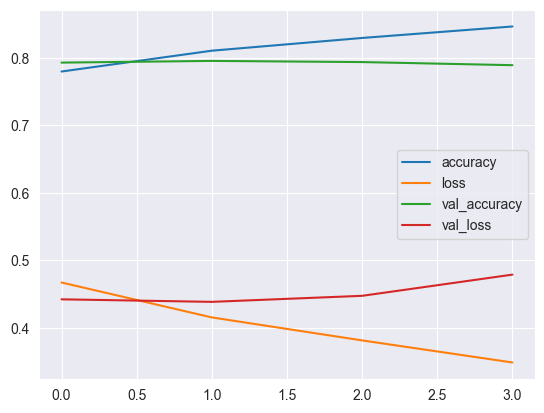

In [41]:
losses= pd.DataFrame(history.history)
losses.plot()

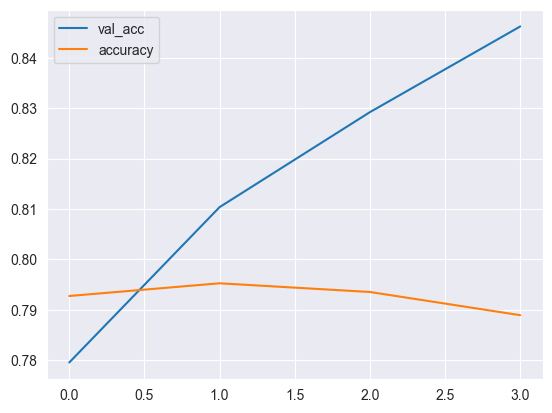

In [42]:
plt.plot(history.history['accuracy'], label='val_acc')
plt.plot(history.history['val_accuracy'], label='accuracy')
plt.legend()

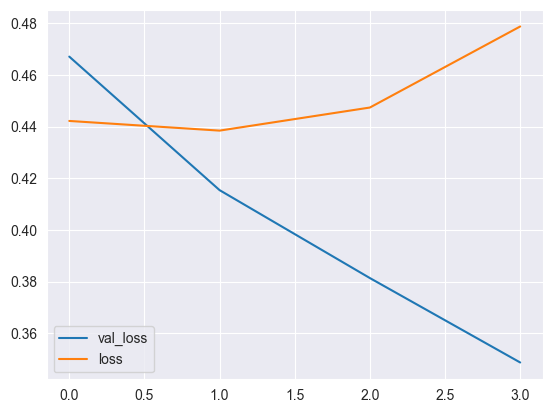

In [43]:
plt.plot(history.history['loss'], label='val_loss')
plt.plot(history.history['val_loss'], label='loss')
plt.legend()

In [44]:
# Binary predictions (already done correctly earlier)
predictions = (model.predict(data_test) > 0.5).astype(int)


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 78s 10ms/step


In [45]:
# Classification report for binary labels
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79    119907
           1       0.79      0.81      0.80    120093

    accuracy                           0.80    240000
   macro avg       0.80      0.80      0.80    240000
weighted avg       0.80      0.80      0.80    240000



In [46]:
model.save('lstm_sentiment_model1.h5')